<a href="https://colab.research.google.com/github/rania-azad/DeepLearning-Course---Limiteless/blob/main/Week%204%3A%20Project%202%20Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Style Transfer

In this notebook, we are going to replicate a technique for style transfer as described in the research paper titled "Image Style Transfer Using Convolutional Neural Networks" by Gatys, using the PyTorch framework.

The paper presents a method where style transfer leverages the features identified in the *VGG19* Network, a deep neural network with 19 layers. This network consists of a sequence of layers, including convolutional layers, pooling layers, and a few fully-connected layers.

The convolutional layers within this network are identified in a specific manner: they are named based on the 'stack' they belong to and their position within that stack. For example, 'Conv_1_1' refers to the very first convolutional layer the image encounters in the first stack. Similarly, 'Conv_2_1' denotes the initial convolutional layer in the second stack. The last and deepest convolutional layer in this network is referred to as 'conv_5_4'.


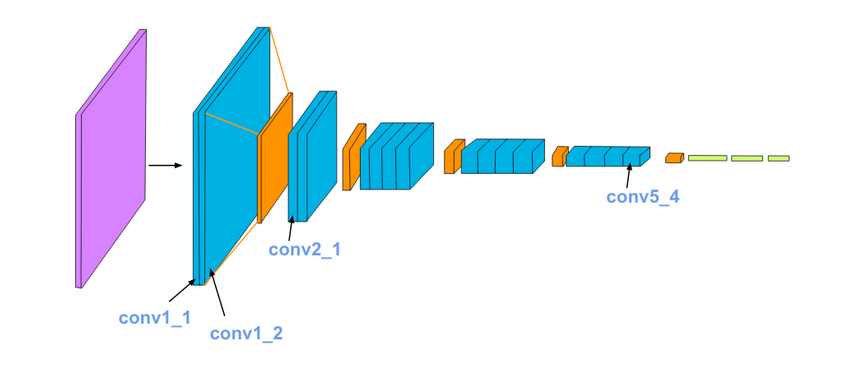

In [ ]:
#content is coming from con1,2,5
Content image ==> conv1_1_content, conv2_1_content, conv5_4_content
Style image ==> conv1_1_style, conv2_1_style, conv5_4_style


Target image (content) #1 ==> conv1_1_target, conv2_1_target, conv5_4_target error: mean(difference) loss.backward optimize.update()
Target image           #2 ==> conv1_1_target, conv2_1_target, conv5_4_target error: mean(difference)



...


### Separate Style from Content:
Style transfer involves distinguishing and recombining the distinct elements of content and style from two images. The process starts with two images: one that provides the content and another that provides the style. The goal is to generate a new image, known as the target image, that merges these aspects:

* The target image should mirror the content of the first image in terms of objects and their layout.
* The artistic elements like style, colors, and textures should resemble those in the second, style-providing image.

# ⚠️ **Important: Use GPU Runtime** ⚠️

To ensure this notebook functions correctly and efficiently, it is **crucial to use a GPU runtime**. Follow these steps to enable GPU acceleration:

1. **Open Runtime settings**: At the top of the page, click on `Runtime` in the menu bar. 🔄

2. **Change the runtime type**: In the dropdown menu, select `Change runtime type`. 🛠️

3. **Select GPU as the hardware accelerator**: In the dialog that appears, under `Hardware accelerator`, choose `GPU T4` from the dropdown menu. 🖥️

4. **Save the settings**: Click `Save` to apply the changes. 💾

By enabling GPU, the computations in this notebook will be significantly faster, especially for tasks like training neural networks, processing large datasets, or performing complex calculations.


In [8]:
# import resources
%matplotlib inline
from PIL import Image # reads and writes and manipulates images
import requests       # HTTP requests (download images from URL)
from io import BytesIO # Input/Output Conversion
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms, models, datasets
import torch
import torch.optim as optim

NameError: name '_C' is not defined

### Load VGG19
VGG19 is a standard network that can be found in torchvision. You can directly load it like a dataset.

In [ ]:
# TODO: get the "features" portion of VGG19 (we will not need the "classifier" portion)
# Already trained on ImageNet
vgg = models.vgg19(pretrained=True).features


for param in vgg.parameters(): # parameters typically refer to the weights and biases of the layers that are learned during the training process.
    param.requires_grad_(False) # In PyTorch, requires_grad_ is an attribute of a tensor that determines whether gradients
# should be calculated for that tensor during backpropagation. If requires_grad_ is set to False, PyTorch will not compute gradients for that tensor,
# which effectively "freezes" the parameters associated with it.



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.3MB/s]


In [ ]:
# TODO: move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load the content and style images
Use any image you like ! What transformations are required to apply to the image ?

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize((size)),# Resize is critical to fit input shape of the model
        transforms.RandomResizedCrop(224), # transforms.CenterCrop(size),
        transforms.ToTensor(), # transform into a Torch tensor
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),  # Normalization values: (0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225))]) # (0.229, 0.224, 0.225))



    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

You can either load the images using a file name or using a URL.

In [ ]:
# load in content and style image
content = load_image('https://www.shutterstock.com/image-photo/cat-surprised-expression-against-orange-600nw-2260003219.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image("https://imgs.search.brave.com/0Iwyoj0DTMsOca4_ESQyUv1CE1mM62JMcwQ4hDmYnrc/rs:fit:860:0:0/g:ce/aHR0cHM6Ly90NC5m/dGNkbi5uZXQvanBn/LzA2LzAyLzI0LzM5/LzM2MF9GXzYwMjI0/Mzk3NV9OdGxCamdG/QU4zcVA5MnhjVmxw/N1Y3TnpvNk5vRVo4/YS5qcGc", shape=content.shape[-2:]).to(device)




In [ ]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

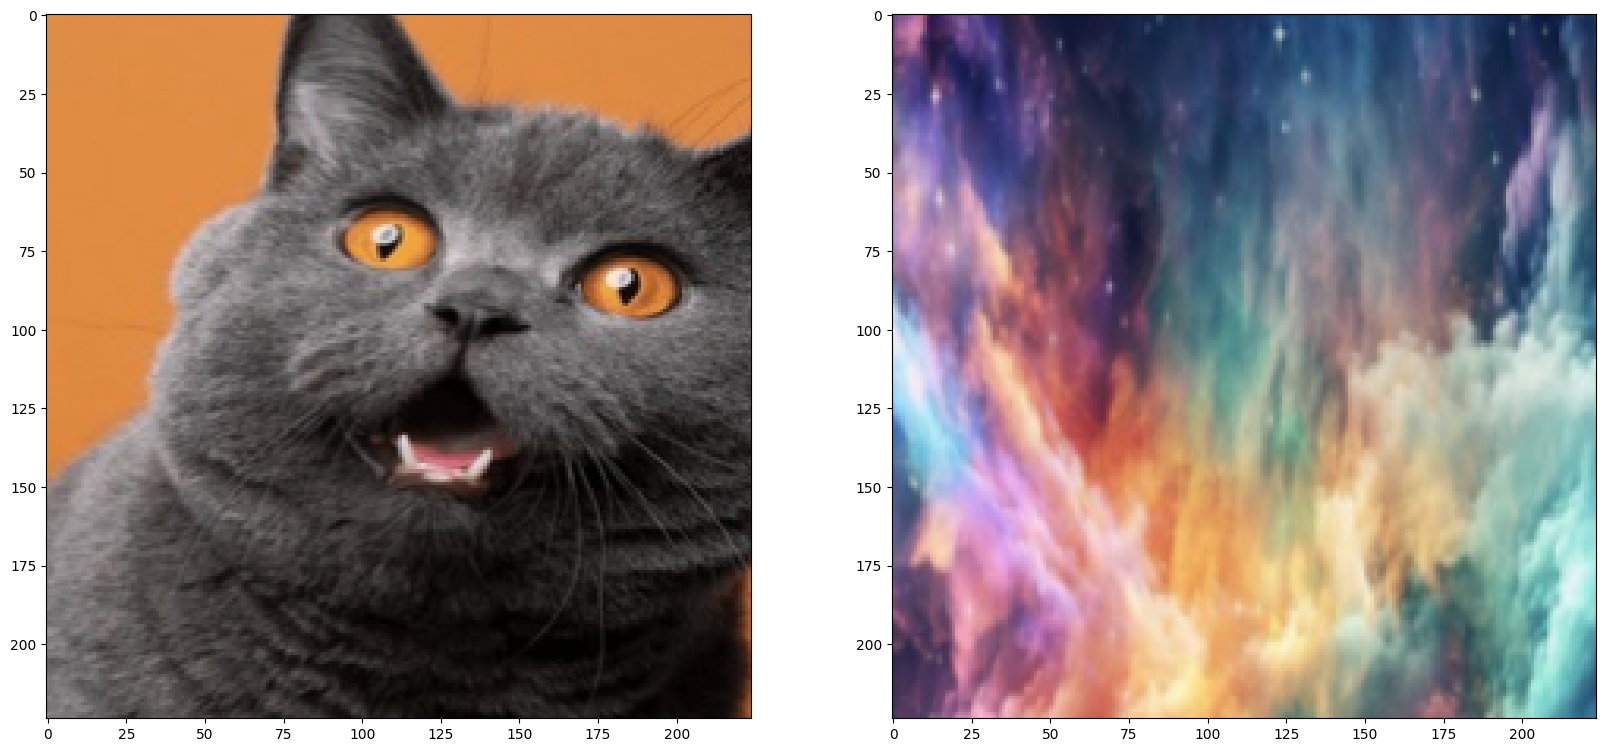

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### Extract the Content & Style features
In VGG19 some layers extract general features that can be considered as the style and other layers extract details of the image that can be considered as the content. Can you figure our which ones ?

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

## Gram Matrix in Style Transfer

The **Gram matrix** is an essential element in the process of style transfer, particularly in the context of neural networks. It is used to capture the style of an image by encoding the correlations between different features in the layers of a network. Here's how you can compute the Gram matrix for a convolutional layer:

1. **Identify the Tensor Dimensions:**
   Each convolutional layer outputs a Tensor, which is a multi-dimensional array with specific dimensions. These dimensions include the batch size, depth (`d`), height (`h`), and width (`w`). You start by extracting these dimensions using:
   ```batch_size, d, h, w = tensor.size()```

2. **Reshape the Tensor:**
Next, reshape this tensor to flatten its spatial dimensions (height and width). This transformation converts the 3D feature maps into a 2D matrix. This step is crucial for preparing the tensor for the Gram matrix calculation.

3. **Compute the Gram Matrix:**
The Gram matrix is calculated by multiplying the reshaped tensor by its transpose. In mathematical terms, if `A` is the reshaped tensor, the Gram matrix `G` is given by `G = A * A^T`, where `A^T` is the transpose of `A`. In PyTorch, this multiplication can be performed using: ```torch.mm(matrix1, matrix2)```
where `matrix1` and `matrix2` represent the reshaped tensor and its transpose, respectively.

The Gram matrix effectively represents the style of an image by encoding how features in a layer are interrelated. In style transfer, these matrices are used to guide the style reconstruction in the target image by comparing and matching the style representation of the style source image.



In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b*d, h*w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

### Our style transfer pipeline!
Let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [ ]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [ ]:
# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Loss and Weights in Style Transfer

In the style transfer process, you have the flexibility to assign different weights to the style representations in each relevant convolutional layer. The recommended range for these weights is between 0 and 1. Assigning higher weights to the initial layers (like `conv1_1` and `conv2_1`) tends to amplify larger style features in your final image. On the other hand, giving more weight to the deeper layers results in a greater focus on finer details. This effect is due to the varying sizes of each layer, which contribute to a layered or multi-scale representation of the image style.

In line with the original research paper, two parameters are used to balance the influence of content and style: alpha (`content_weight`) and beta (`style_weight`). The proportion between these weights dictates the level of stylization in your final image. A common approach is to keep the `content_weight` fixed at 1 and adjust the `style_weight` to find the desired balance between the original content and the style influence.


In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

### Updating the Target & Calculating Losses
Now we need to update our tagret image by minimizing the gram matrix loss until we are satisfied with the image we have.


Total loss:  2542246.75


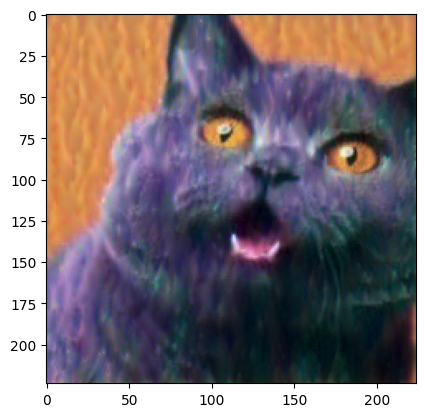

Total loss:  1307137.0


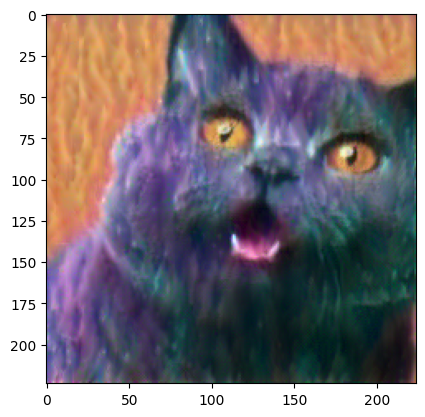

Total loss:  828782.0625


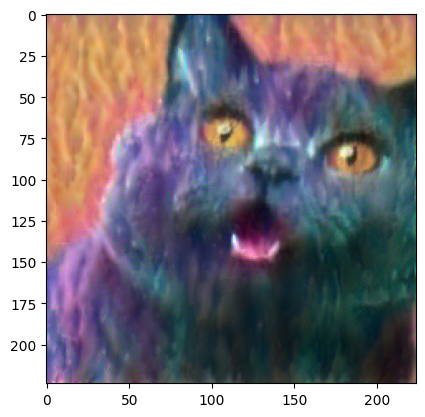

Total loss:  570149.3125


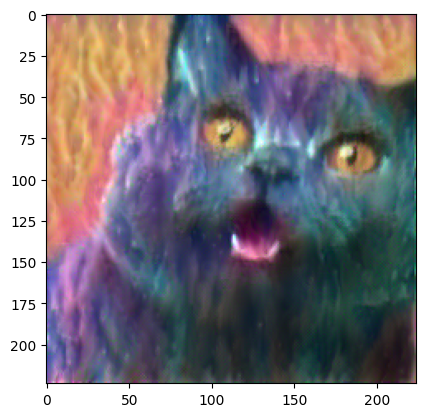

Total loss:  420986.75


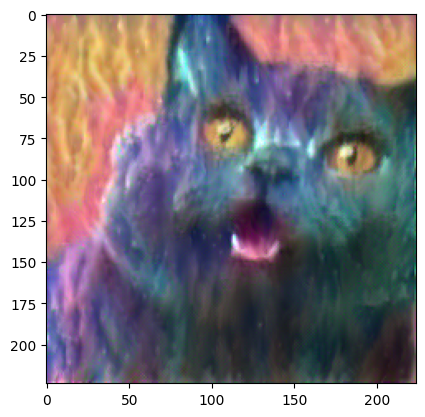

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
# Learn the pixel
optimizer = optim.Adam([target], lr=0.003) # TODO: try multiple learning rates
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss to reach min, the weight is the output imgae, compare the output img cont, then compare it to target
    #
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
       # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Display target image!

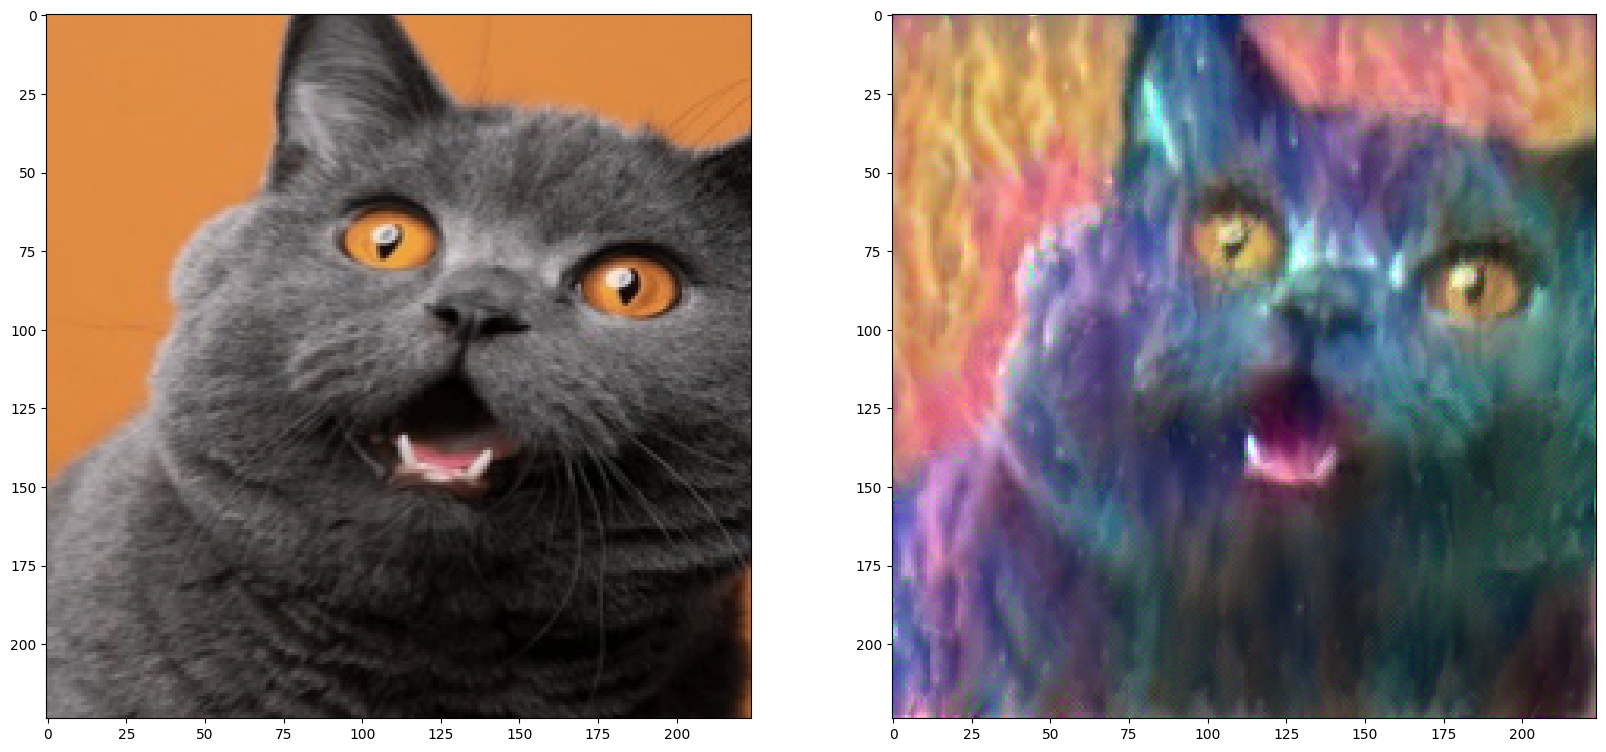

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))